# Homework 7

## Option 2 — Audio+Text Retrieval with ASR Errors

Goal:
- Create clean text docs and noisy ASR-like docs (with recognition errors).
- Convert text to phoneme sequences (CMU Pronouncing Dictionary).
- Index documents using phoneme trigrams (phoneme 3-grams).
- Split the query into phoneme trigrams.
- Retrieve the closest documents using cosine similarity and visualize results.


### Imports + Setup

In [34]:
import os
import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt


### Create the documents (2 clean + 2 ASR versions)

In [36]:
# Folder to save the docs (optional, but nice for the assignment)
os.makedirs("docs", exist_ok=True)

# 2 clean docs
doc_clean_1 = """
Speech recognition is an important topic in information retrieval.
We index spoken content so users can search and retrieve relevant documents.
"""

doc_clean_2 = """
Cooking recipes and kitchen tips: boil pasta, chop onions, and bake bread.
This document is not about speech recognition.
"""

# 2 ASR-like docs (introduce errors in query-related words)
# Examples of ASR-ish errors:
# - substitution: speech -> beach
# - splitting/merging: retrieval -> re trieval
# - near-sound word: recognition -> wreck a nation (very ASR-ish style)
doc_asr_1 = """
Beach wreck a nation is important in information re trieval.
We index spoken content so users can search and re trieve relevant documents.
"""

doc_asr_2 = """
Speech rekognition helps users find information.
Search and retrival are common tasks in informashun retrieval systems.
"""

docs = {
    "clean_doc_1.txt": doc_clean_1,
    "clean_doc_2.txt": doc_clean_2,
    "asr_doc_1.txt": doc_asr_1,
    "asr_doc_2.txt": doc_asr_2,
}

for name, text in docs.items():
    with open(os.path.join("docs", name), "w", encoding="utf-8") as f:
        f.write(text.strip())

print("Created files:")
for name in docs:
    print(" -", os.path.join("docs", name))


Created files:
 - docs\clean_doc_1.txt
 - docs\clean_doc_2.txt
 - docs\asr_doc_1.txt
 - docs\asr_doc_2.txt


### Define the query (3–4 words, clean)

In [38]:
query = "speech recognition retrieval"
print("Query:", query)


Query: speech recognition retrieval


### CMU Pronouncing Dictionary (phonemes)

In [40]:
import nltk

def ensure_cmudict():
    try:
        from nltk.corpus import cmudict
        _ = cmudict.entries()[:5]
        return cmudict
    except Exception:
        nltk.download("cmudict")
        from nltk.corpus import cmudict
        return cmudict

cmudict = ensure_cmudict()
CMU = cmudict.dict()

def normalize_word(w: str) -> str:
    w = w.lower()
    w = re.sub(r"[^a-z']", "", w)
    return w

def word_to_phonemes(word: str):
    """
    Convert a word to a list of ARPAbet phoneme tokens using CMUdict.
    If OOV (not in CMUdict), fall back to spelling characters.
    """
    w = normalize_word(word)
    if not w:
        return []
    if w in CMU:
        # Take the first pronunciation
        phs = CMU[w][0]
        # Remove stress digits: AH0 -> AH
        phs = [re.sub(r"\d", "", p) for p in phs]
        return phs
    # Fallback: character-level pseudo-phonemes
    return list(w)

def text_to_phoneme_tokens(text: str):
    words = re.findall(r"[A-Za-z']+", text)
    tokens = []
    for w in words:
        tokens.extend(word_to_phonemes(w))
    return tokens


### Build phoneme 3-grams (phoneme trigrams)

In [42]:
def phoneme_trigrams_from_tokens(tokens):
    """
    tokens: list of phoneme tokens, e.g. ["S","P","IY","CH",...]
    returns: list of trigram strings, e.g. ["S-P-IY", "P-IY-CH", ...]
    """
    if len(tokens) < 3:
        return []
    return ["{}-{}-{}".format(tokens[i], tokens[i+1], tokens[i+2]) for i in range(len(tokens) - 2)]

def phoneme_trigrams(text: str):
    tokens = text_to_phoneme_tokens(text)
    return phoneme_trigrams_from_tokens(tokens)

# quick sanity check
print(phoneme_trigrams("speech recognition retrieval")[:10])


['S-P-IY', 'P-IY-CH', 'IY-CH-R', 'CH-R-EH', 'R-EH-K', 'EH-K-AH', 'K-AH-G', 'AH-G-N', 'G-N-IH', 'N-IH-SH']


### Vectorize docs + query using TF-IDF over phoneme trigrams

In [44]:
doc_names = list(docs.keys())
doc_texts = [docs[n] for n in doc_names]

vectorizer = TfidfVectorizer(
    analyzer=phoneme_trigrams,   # returns token list (phoneme 3-grams)
    lowercase=False              # we already handle normalization
)

X_docs = vectorizer.fit_transform(doc_texts)
X_query = vectorizer.transform([query])

print("Docs matrix shape:", X_docs.shape)
print("Query vector shape:", X_query.shape)
print("Vocabulary size:", len(vectorizer.vocabulary_))


Docs matrix shape: (4, 245)
Query vector shape: (1, 245)
Vocabulary size: 245


### Cosine similarity + ranking

In [46]:
sims = cosine_similarity(X_query, X_docs).flatten()

results = pd.DataFrame({
    "doc": doc_names,
    "cosine_similarity": sims
}).sort_values("cosine_similarity", ascending=False)

results.reset_index(drop=True, inplace=True)
results


,doc,cosine_similarity
0,clean_doc_1.txt,0.479338
1,clean_doc_2.txt,0.201723
2,asr_doc_2.txt,0.166599
3,asr_doc_1.txt,0.093316


### Results

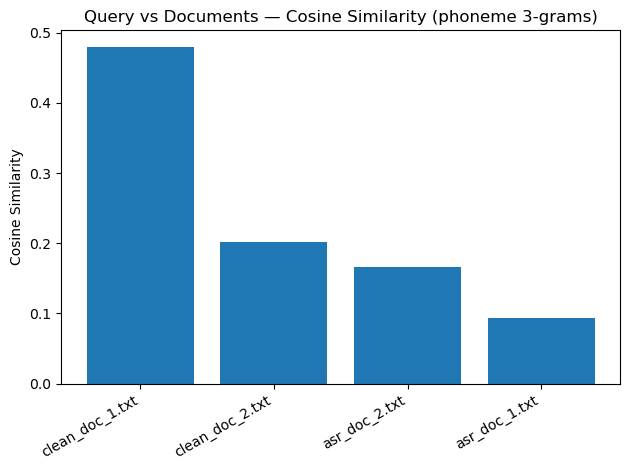

In [48]:
plt.figure()
plt.bar(results["doc"], results["cosine_similarity"])
plt.xticks(rotation=30, ha="right")
plt.title("Query vs Documents — Cosine Similarity (phoneme 3-grams)")
plt.ylabel("Cosine Similarity")
plt.tight_layout()
plt.show()


In [49]:
top_doc = results.iloc[0]
print("Most similar document:", top_doc["doc"])
print("Similarity score:", float(top_doc["cosine_similarity"]))

print("\nRanked results:")
for i, row in results.iterrows():
    print(f"{i+1}. {row['doc']}  ->  {row['cosine_similarity']:.4f}")


Most similar document: clean_doc_1.txt
Similarity score: 0.47933843285399436

Ranked results:
1. clean_doc_1.txt  ->  0.4793
2. clean_doc_2.txt  ->  0.2017
3. asr_doc_2.txt  ->  0.1666
4. asr_doc_1.txt  ->  0.0933
